In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# the below code is from Nicholas Burgess:
%pip install yfinance
import yfinance as yf
import matplotlib.pyplot as plt

%matplotlib inline

# disable warnings

import warnings
warnings.filterwarnings('ignore')

# allow multiple output per cell

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import statsmodels.api as sm

# import the adfuller (ADF) test
from statsmodels.tsa.stattools import adfuller 

%pip install quantstats
import quantstats as qs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 36.0 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 3.3 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.1-cp310-cp310-linux_x86_64.whl size=291653 sha256=3037888e8365240c619d1339275fb3f5fd3d1a9c2d06b470e46fa16359046bf5
  Stored in directory: /root/.cache/pip/wheels/d7/35/5c/1374782be033462df5f40174d8d879519d64ed8c25a1977554
Successfully built peewee
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
sp500 = "^GSPC"
google = "GOOG"
tickers = [sp500, google]

start = "2020-01-01"
end = "2024-01-01"

# create DataFrame of stock returns
df = pd.DataFrame(columns = tickers)

# download adjusted close returns from yfinance
df[tickers[0]] = yf.download(tickers[0], start, end, progress = False)['Adj Close']
df[tickers[1]] = yf.download(tickers[1], start, end, progress = False)['Adj Close']

df.head()

,^GSPC,GOOG
Date,,
2020-01-02,3257.850098,68.368500
2020-01-03,3234.850098,68.032997
2020-01-06,3246.280029,69.710503
2020-01-07,3237.179932,69.667000
2020-01-08,3253.050049,70.216003


Text(0, 0.5, '^GSPC')

Text(0, 0.5, 'GOOG')

Text(0.5, 1.0, '^GSPC vs GOOG')

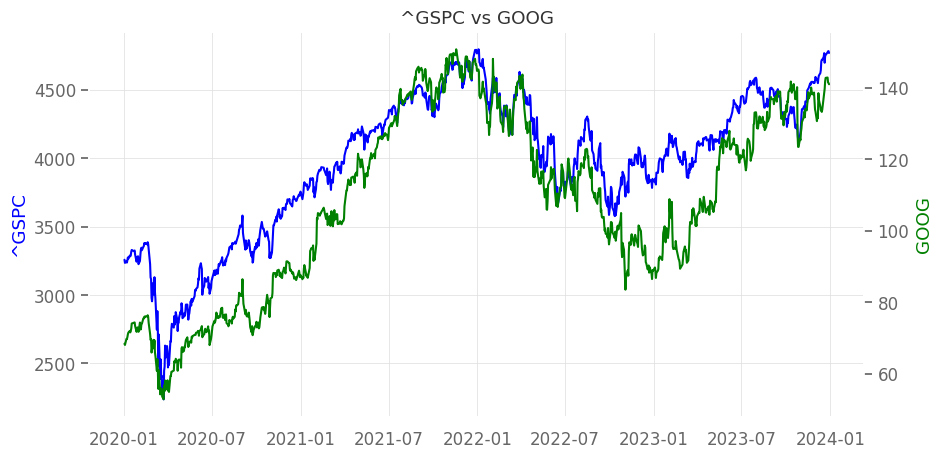

In [4]:
# plot market data
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(df.index, df[tickers[0]], color = 'blue')
plt.ylabel(tickers[0], color = 'blue')
ax1 = ax.twinx()
ax1.plot(df.index, df[tickers[1]], color = 'green')
plt.ylabel(tickers[1], color = 'green')
plt.grid()
plt.title(f'{tickers[0]} vs {tickers[1]}')
plt.show()

In [5]:
# compute beta or hedge ratio between Y (Google) and X (S&P 500)

Y = df[tickers[0]]
x = df[tickers[1]]

# add constant intercept term
X = sm.add_constant(x)

# perform OLS
result = sm.OLS(Y, X).fit()

# beta or hedge ratio
hedge_ratio = result.params[1]
print(f'Hedge Ratio: {hedge_ratio: .4f}')

Hedge Ratio:  19.5973


In [6]:
# compute the spread
df['spread'] = Y - hedge_ratio * x

# also compute the spread log return
df['log_return'] = np.log(df['spread'] / df['spread'].shift(1))

# display the updated DataFrame
df.head()

,^GSPC,GOOG,spread,log_return
Date,,,,
2020-01-02,3257.850098,68.368500,1918.008969,NaN
2020-01-03,3234.850098,68.032997,1901.583930,-0.008600
2020-01-06,3246.280029,69.710503,1880.139207,-0.011341
2020-01-07,3237.179932,69.667000,1871.891649,-0.004396
2020-01-08,3253.050049,70.216003,1877.002752,0.002727


Text(0.5, 1.0, 'Spread')

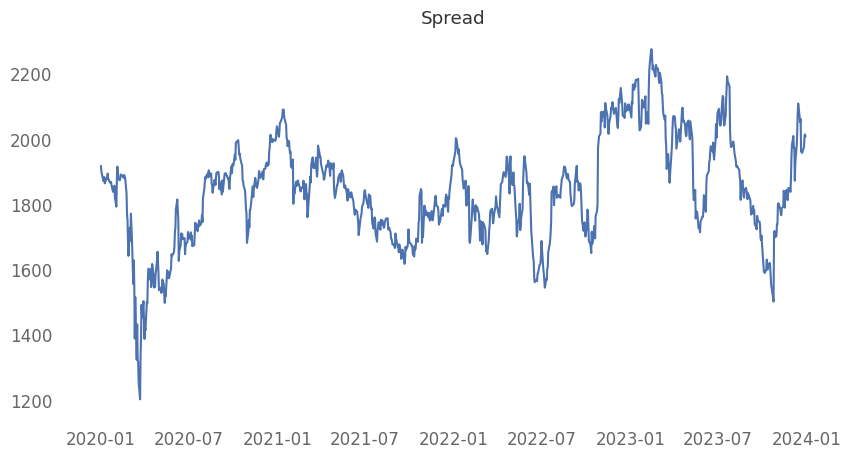

In [7]:
# plot the spread 
fig = plt.figure(figsize = (10, 5))
plt.plot(df['spread'])
plt.grid()
plt.title('Spread')
plt.show()

In [8]:
# test the spread for stationary using ADF
adf = adfuller(df['spread'], maxlag = 1)

# p-value
p_value = adf[1]

# print ADF results
print(f'ADF result parameters \n {adf} \n')

# print test statistic 
print(f'Test statistic: {adf[0]:.4f}')

# print critical value
print(f'Critical value: {adf[4]["5%"]:.4f}')

# print p-value
print(f'P-value: {adf[1]*100:.4f}')

ADF result parameters 
 (-3.3309721139421353, 0.013549524424124727, 0, 1005, {'1%': -3.4368734638130847, '5%': -2.8644201518188126, '10%': -2.5683035273879358}, 9950.249190586503) 

Test statistic: -3.3310
Critical value: -2.8644
P-value: 1.3550


In [9]:
# method to print stationary result
def is_stationary(p_value):
    if (p_value < 0.05):
        print(f'Series is stationary (p-value: {adf[1]*100:.4f}%)')
    else:
        print(f'Series NOT stationary (p-value: {adf[1]*100:.4f}%)')
    return

is_stationary(p_value)

Series is stationary (p-value: 1.3550%)


In [10]:
# compute mean and std using window specified
window = 30
df['mean'] = df['spread'].ewm(span = window).mean()
df['std'] = df['spread'].ewm(span = window).std()

# drop NaN values
df.dropna(inplace = True)

# compute the Z-score
df['z_score'] = (df['spread'] - df['mean']) / df['std']

# z-score boundaries
df['z_up'] = 2.0
df['z_down'] = -2.0

# long trading signals
long_entry = (df['z_score'] <= df['z_down'])
long_exit = (df['z_score'] >= 0)

# initialize long position column to NaN
df['long_pos'] = np.nan

# apply long trading strategies
df.loc[long_entry, 'long_pos'] = 1
df.loc[long_exit, 'long_pos'] = 0

# forward fill NaN values
df['long_pos'].fillna(method = 'ffill', inplace = True)

# fill any remaining NaN values with zero
df['long_pos'].fillna(0, inplace = True)

# short trading signals
short_entry = (df['z_score'] >= df['z_down'])
short_exit = (df['z_score'] <= 0)

# initialize short position column to NaN
df['short_pos'] = np.nan

# apply short trading strategies
df.loc[short_entry, 'short_pos'] = -1
df.loc[short_exit, 'short_pos'] = 0

# forward fill NaN values
df['short_pos'].fillna(method = 'ffill', inplace = True)

# fill any remaining NaN values with zero
df['short_pos'].fillna(0, inplace = True)

# total trading position 
df['total_pos'] = df['long_pos'] + df['short_pos']

Text(0, 0.5, 'Z-score')

Text(0, 0.5, 'Spread')

Text(0.5, 1.0, 'Z-Scores')

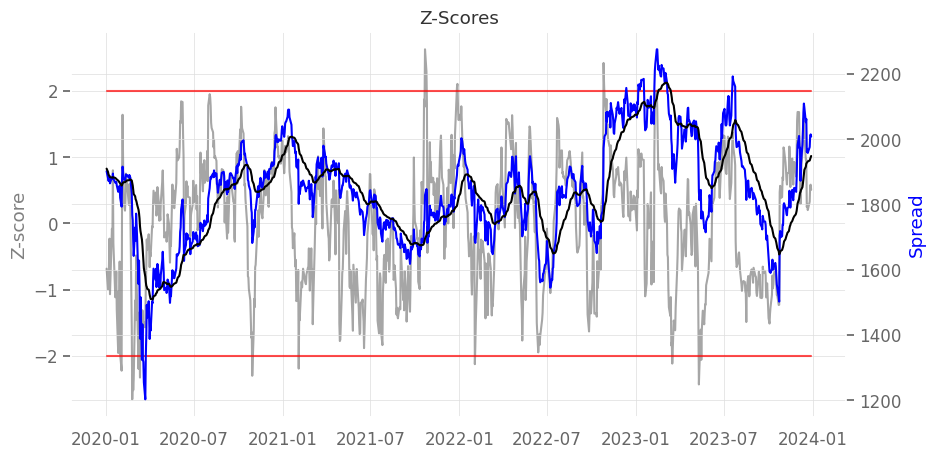

In [11]:
# Plot the Z-Scores
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df.index, df['z_score'], color='grey', alpha=0.7)
ax.plot(df.index, df['z_up'], color='red', alpha=0.7)
ax.plot(df.index, df['z_down'], color='red', alpha=0.7)
ax.set_ylabel('Z-score', color='grey')
ax1 = ax.twinx()
ax1.plot(df.index, df['spread'], color='blue')
ax1.plot(df.index, df['mean'], color='black')
ax1.set_ylabel('Spread', color='blue')
plt.title('Z-Scores')
plt.show()


Text(0, 0.5, 'Spread')

Text(0, 0.5, 'Trading Position')

Text(0.5, 1.0, 'Trading Positions')

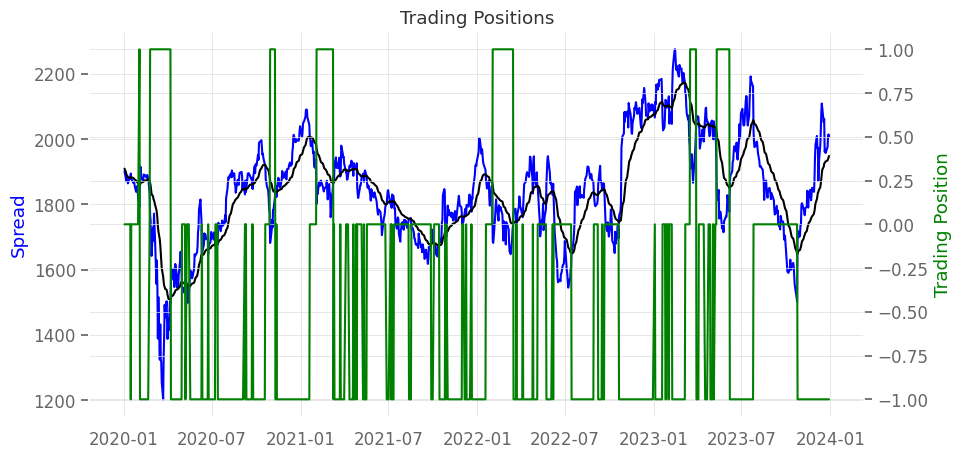

In [12]:
# plot trading positions
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(df.index, df['spread'], color='blue')
plt.plot(df.index, df['mean'], color='black')
plt.ylabel('Spread', color='blue')
ax1 = ax.twinx()
ax1.plot(df.index, df['total_pos'], color='green')
ax1.set_ylabel('Trading Position', color='green')
plt.title('Trading Positions')
plt.show()

In [13]:
# compute strategy returns - shift position by 1 Day to mitigate 
df['strategy_returns'] = df['total_pos'].shift(1) * df['log_return']
strategy_mean = df['strategy_returns'].mean()
strategy_std = df['strategy_returns'].std()

# Compute the Sharpe Ratio
# assume 5.0% per year
risk_free_rate = 0.05 

# Daily Sharpe Ratio
# Note: we convert risk-free rate to a daily rate i.e. divide by 252
sharpe_daily = (strategy_mean - (risk_free_rate/252) ) / strategy_std
print(f'Daily Sharpe Ratio: {sharpe_daily:.4f}')

# Annualized Sharpe Ratio
# Scale daily by t/sqrt(t) = sqrt(t) i.e. sqrt(252)
sharpe_annual = sharpe_daily * np.sqrt(252)
print(f'Annual Sharpe Ratio: {sharpe_annual:.4f}')

Daily Sharpe Ratio: -0.0083
Annual Sharpe Ratio: -0.1319


                    Strategy
------------------  ----------
Start Period        2020-01-06
End Period          2023-12-29
Risk-Free Rate      5.0%
Time in Market      65.0%

Cumulative Return   -7.24%
CAGR﹪              -1.29%

Sharpe              -0.13
Prob. Sharpe Ratio  7.15%
Sortino             -0.18
Sortino/√2          -0.13
Omega               0.97

Max Drawdown        -34.63%
Longest DD Days     611

Gain/Pain Ratio     0.01
Gain/Pain (1M)      0.07

Payoff Ratio        1.0
Profit Factor       1.01
Common Sense Ratio  1.04
CPC Index           0.51
Tail Ratio          1.03
Outlier Win Ratio   7.49
Outlier Loss Ratio  3.06

MTD                 -3.71%
3M                  -15.81%
6M                  -17.09%
YTD                 -2.89%
1Y                  -3.44%
3Y (ann.)           1.86%
5Y (ann.)           -1.29%
10Y (ann.)          -1.29%
All-time (ann.)     -1.29%

Avg. Drawdown       -7.83%
Avg. Drawdown Days  112
Recovery Factor     0.18
Ulcer Index         0.14
Serenity Index   

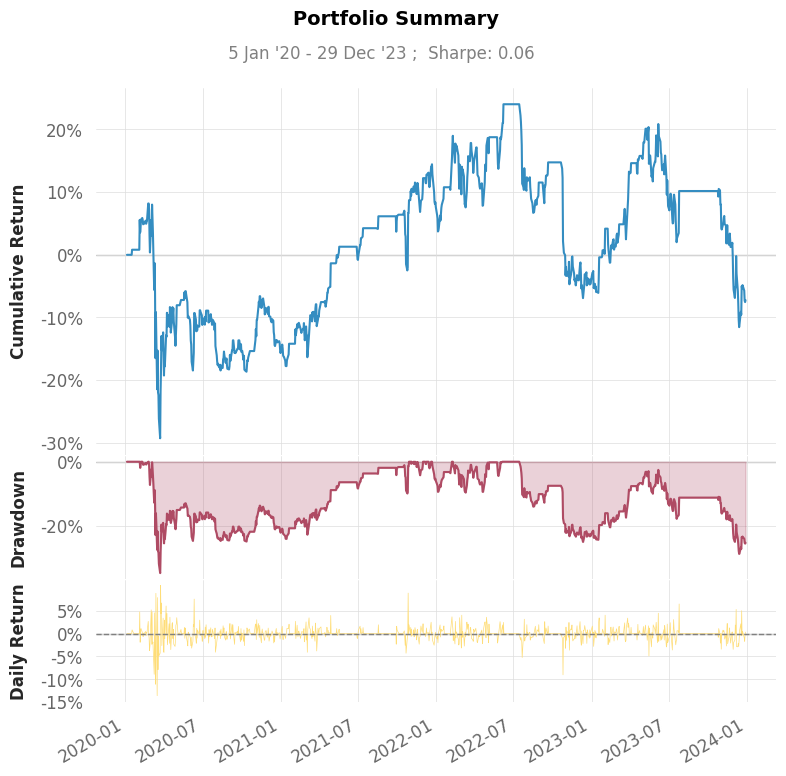

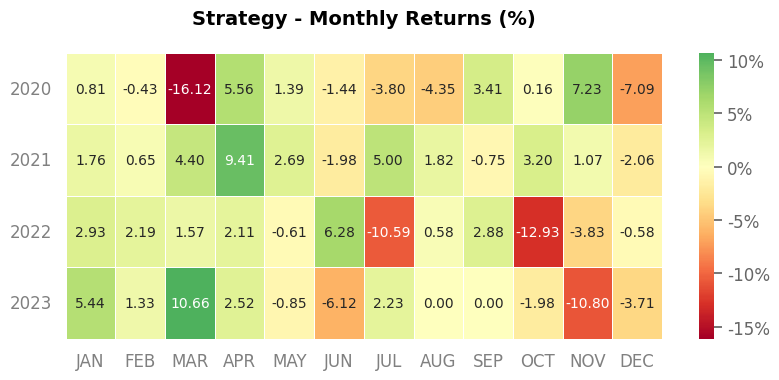

In [14]:
# QuantStats Tearsheet
qs.reports.basic(df['strategy_returns'], rf = risk_free_rate)

In [ ]:
\\\